In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import os
import PIL
import torchvision.transforms as transforms

import models
import utils

from mltools.networks import networks
from mltools.utils import cuda_tools
from mltools import ml_utils

device=cuda_tools.get_freer_device()

import importlib
importlib.reload(models)
importlib.reload(utils)
importlib.reload(ml_utils)

ModuleNotFoundError: No module named 'torchvision'

In [4]:
csvpath="/n/holylfs06/LABS/finkbeiner_lab/Users/cfpark00/datadir/ML/datasets/celebA/list_attr_celeba.txt"
imgdir="/n/holylfs06/LABS/finkbeiner_lab/Users/cfpark00/datadir/ML/datasets/celebA/imgs"
files_=glob.glob(os.path.join(imgdir, "*.png"))
files={}
for f in files_:
    name=os.path.basename(f)
    files[name.replace(".png","")]=f
header=list(np.loadtxt(csvpath, skiprows=1, max_rows=1, dtype=str))
attributess_=np.loadtxt(csvpath, skiprows=2, dtype=str)
attributess={}
for i, attrs in enumerate(attributess_):
    key=attrs[0].replace(".jpg","")
    attributess[key]=np.array([1 if x=="1" else 0 for x in attrs[1:]]).astype(np.int64)
header

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [16]:
i_h1=header.index('Male')
i_h2=header.index('Smiling')

In [17]:
#examples
combinations=[(0,0), (0,1), (1,0), (1,1)]
#random order
n_tot=len(files)
randind=np.random.choice(n_tot,n_tot,replace=False)
examples={}
for key in np.array(list(files.keys()))[randind]:
    if (attributess[key][i_h1],attributess[key][i_h2]) in examples:
        continue
    elif (attributess[key][i_h1],attributess[key][i_h2]) in combinations:
        examples[(attributess[key][i_h1],attributess[key][i_h2])]=key
    if len(examples)==len(combinations):
        break

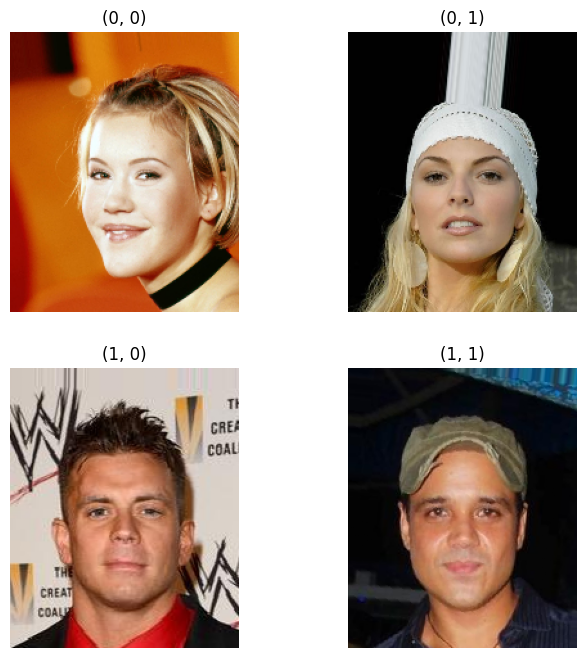

In [26]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(plt.imread(files[examples[combinations[i]]]))
    plt.title(str(combinations[i]))
    plt.axis("off")

In [31]:
bins={(0,1):[], (1,0):[], (0,0):[], (1,1):[]}
for key in attributess.keys():
    attributes=attributess[key]
    bins[(attributes[i_h1],attributes[i_h2])].append(key)
len(bins[(0,0)]),len(bins[(0,1)]), len(bins[(1,0)]), len(bins[(1,1)])

(115218, 2947, 77563, 6871)

In [32]:
selections=[(1,0),(1,1),(0,0)]

In [33]:
n_per=6871
selected={}
for sel in selections:
    randinds=np.random.choice(len(bins[sel]), n_per, replace=False)
    selected[sel]=list(np.array(bins[sel])[randinds])
print([len(selected[sel]) for sel in selections])

[6871, 6871, 6871]


In [34]:
n_per=2947
selected_classifier={}
for sel in selections:
    randinds=np.random.choice(len(bins[sel]), n_per, replace=False)
    selected_classifier[sel]=list(np.array(bins[sel])[randinds])
print([len(selected_classifier[sel]) for sel in selections])

[2947, 2947, 2947]


In [35]:
#torch.save(selected, "./data/celeba/selected3.pth")
#torch.save(selected_classifier, "./data/celeba/selected_classifier3.pth")

In [50]:
selections=[(1,0),(1,1),(0,0)]

In [62]:
n_per=30000
selected={}
for sel in selections:
    randinds=np.random.choice(len(bins[sel]), n_per, replace=False)
    selected[sel]=list(np.array(bins[sel])[randinds])
torch.save(selected, "./data/celeba/selected2.pth")

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, files_dict, vectors_dict):
        self.keys=list(files_dict.keys())
        self.files_dict=files_dict
        self.vectors_dict=vectors_dict
        #add translation and color small gitter
        self.trf=transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(), transforms.ColorJitter(0.1,0.1,0.1,0.1), transforms.RandomHorizontalFlip()])
    def __getitem__(self, idx):
        key=self.keys[idx]
        file=self.files_dict[key]
        if isinstance(file, str):
            img=PIL.Image.open(file)
        elif isinstance(file, PIL.Image.Image):
            img=file
        else:
            raise ValueError("Unsupported file type")
        img=self.trf(img)
        vector=self.vectors_dict[key]
        return img, vector
    def __len__(self):
        return len(self.keys)

In [26]:
#for run

In [27]:
bins={(0,1):[], (1,0):[], (0,0):[], (1,1):[]}
for key in attributess.keys():
    attributes=attributess[key]
    bins[(attributes[i_h1],attributes[i_h2])].append(key)

In [20]:
len(bins[(0,0)]),len(bins[(0,1)]), len(bins[(1,0)]), len(bins[(1,1)])

(118162, 3, 76020, 8414)

In [31]:
files_selected={}
vectors_selected={}
n_selected=0
n_not_selected=0
for key in attributess.keys():
    attributes=attributess[key]
    if attributes[i_h1]==1 and attributes[i_h2]==1:
        n_not_selected+=1
    else:
        files_selected[key]=PIL.Image.open(files[key])
        #files_selected[key]=files[key]
        attrs=torch.tensor(attributes[[i_h1,i_h2]])
        vectors_selected[key]=torch.nn.functional.one_hot(attrs,2).float().view(-1)
        n_selected+=1
    if n_selected>3000:
        break
n_selected, n_not_selected

(3001, 36)

total: 3001
tensor(0.) tensor(0.9133) torch.Size([3, 64, 64]) torch.float32 torch.Size([4]) torch.float32


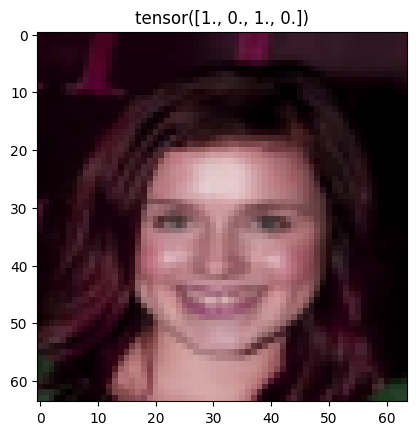

In [32]:
dataset=Dataset(files_selected, vectors_selected)
print("total:",len(dataset))
x,y=dataset[np.random.randint(len(dataset))]
plt.imshow(x.permute(1,2,0))
plt.title(y)
print(x.min(), x.max(),x.shape,x.dtype,y.shape,y.dtype)

In [33]:
batch_size=64
dl_tr=torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


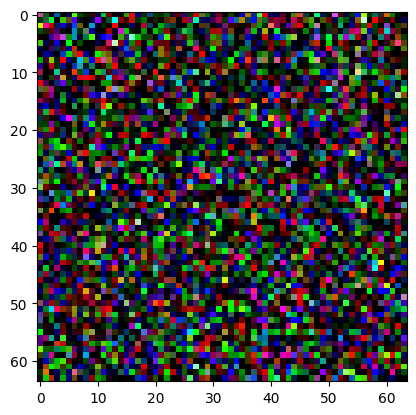

In [34]:
beta_settings={"gamma_max":10.0, "gamma_min":-5.0, "noise_schedule":"learned_linear", "type":"logsnr"}
net=networks.CUNet(shape=(3,64,64),chs=[64,128,256],mid_attn=True,num_res_blocks=2,norm_groups=4,v_conditioning_dims=[4],t_conditioning=True)
vdm=models.GenVDiff(net=net,beta_settings=beta_settings,data_noise=1e-3)
vdm.optimizer=torch.optim.AdamW(vdm.parameters(), lr=1e-4, weight_decay=1e-5)
vdm=vdm.to(device)
example=vdm.generate(c=torch.randn(1,4).to(device)).detach().cpu()
plt.imshow(example[0].permute(1,2,0))

In [35]:
def batch_to_kwargs(batch):
    x,c=batch
    x=x.to(device)
    c=c.to(device)
    return {"x":x,"c":c}
train_results=ml_utils.train(model=vdm,dl_tr=dl_tr,
device=device,callback_steps=[],callbacks=[],n_steps=10_000,batch_to_kwargs=batch_to_kwargs)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training: 100%|██████████| 10000/10000 [14:20<00:00, 11.62it/s]


In [39]:
train_results.keys()

dict_keys(['callback_steps', 'online_losses', 'time_tr', 'time_callbacks'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


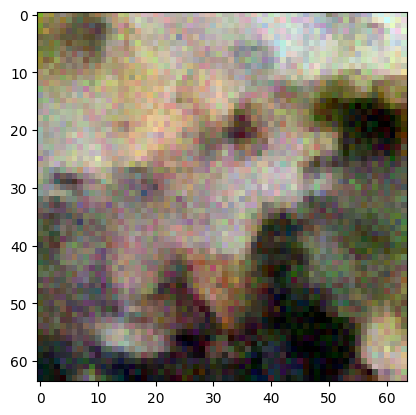

In [44]:
example=vdm.generate(c=torch.tensor([[1.,0.,1.,0.]]).to(device)).detach().cpu()
plt.imshow(example[0].permute(1,2,0))

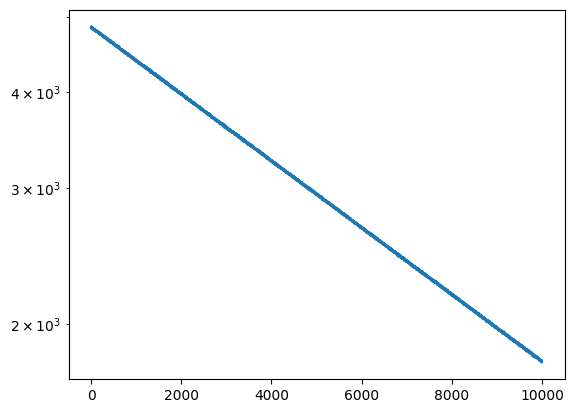

In [45]:
plt.plot(train_results["online_losses"])
plt.yscale("log")